# 0. 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import re
from collections import Counter
from kiwipiepy import Kiwi
kiwi=Kiwi()
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# 1. 데이터 확인

In [2]:
train_data_path ="~/aiffel/dktc/data/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [3]:
common_data_path ="~/aiffel/aiffel/dlthon/common_conversations(1000).csv"
common_data = pd.read_csv(common_data_path)
common_data.head()

,text,label
0,보고싶더랴.. 오라고는 못하겠고\n아이고..담주에 가야겠네\n가끔 가면 좋아하시는데...,일반 대화
1,아니 나 다음주까지 완결치는게 목표인데 의자 안옵니까?ㅠㅠ\nㅠㅠㅠㅠㅠㅠ 개빡쳐 진...,일반 대화
2,맞아 현실적인 조언이군\n근데 난 오히려 저런 현실적인 조언이 조아\nㅋㅋㄱㅋ#@기...,일반 대화
3,나 엘레베이터안인데 애기가 나 발로 차서\n어엉 ㅇㅁㅇ 왜차!\n걍 안쳐다보고 그러...,일반 대화
4,#@기타#데이에 다들 시다 뛸 준비하고와\n#@이름#시켜 #@이름#가 모형다만들엇어...,일반 대화


In [4]:
common_data.rename(columns={'text': 'conversation', 'label': 'class'}, inplace=True)
train_data = pd.concat([train_data, common_data], ignore_index=True)
train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data.head()

,idx,class,conversation
0,1588.0,갈취 대화,어이 거기!\n네? 저요?\n그럼 거기 너 말고 또 누구 있어? 이리 와봐.\n왜 ...
1,878.0,기타 괴롭힘 대화,여기 왜이래\n왜 그러십니까 손님\n서비스가 엉망이야\n진정하시고 앉으세요\n나 가...
2,NaN,일반 대화,혼자울지 우는거 난 보이는거 싫어\n아하 우니까 좀 나아졌어?\n눈 개부엇죠\n진짜...
3,3316.0,기타 괴롭힘 대화,지금 누구랑 연락해?\n친구 \n전 여자친구 아니고?\n뭐? 아 또 의심 지겹다 진...
4,3694.0,협박 대화,너는 여기에 와서는 안되는 사람이야 알어?\n네? 저는 애들을 가르킨 죄밖에 없어요...


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4950 entries, 0 to 4949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   idx           3950 non-null   float64
 1   class         4950 non-null   object 
 2   conversation  4950 non-null   object 
dtypes: float64(1), object(2)
memory usage: 116.1+ KB
None


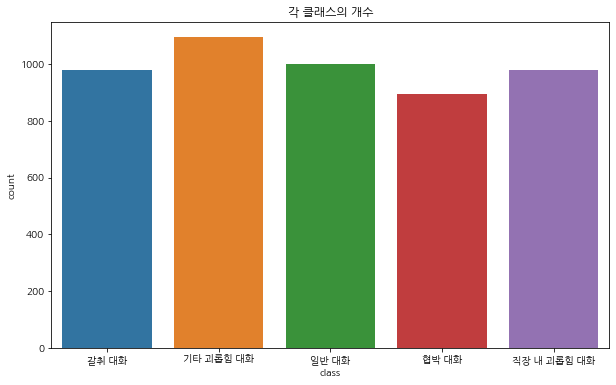

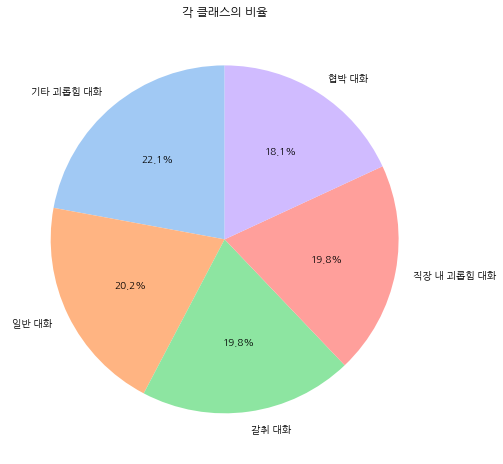

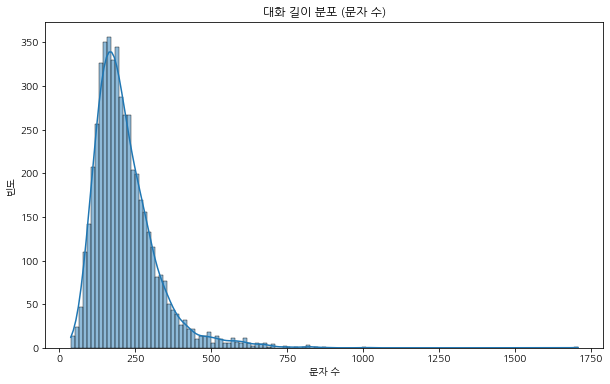

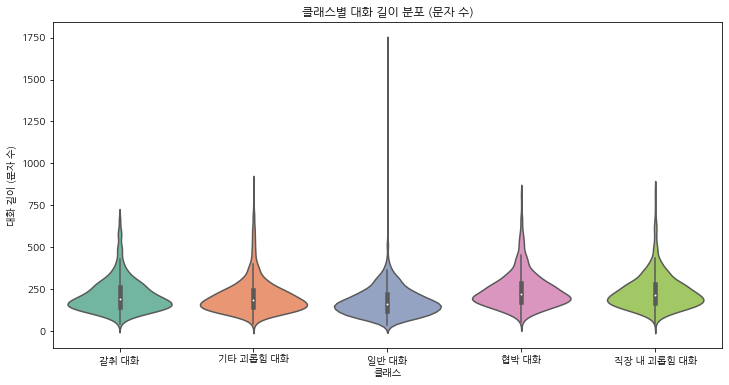

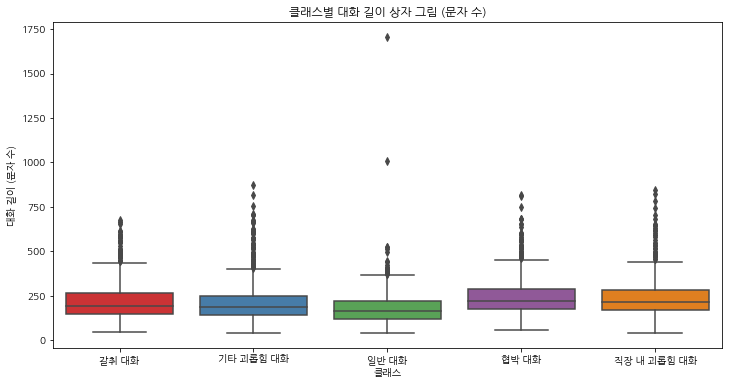

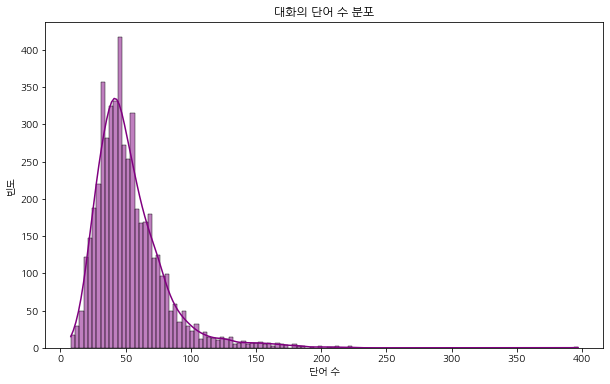

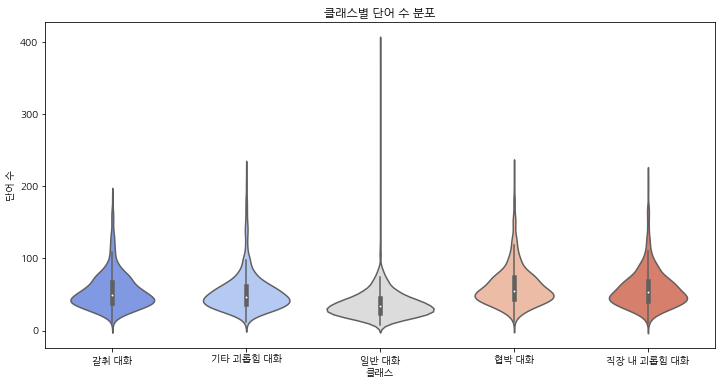

In [5]:
# 한글 폰트 설정 (여기서는 'NanumGothic' 폰트를 사용)
plt.rcParams['font.family'] = 'NanumGothic'

# 데이터 기본 정보 확인
print("Train Data Info:")
print(train_data.info())  # 데이터 타입, 결측치 확인

# 1. 'class' 컬럼의 분포 확인
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=train_data)
plt.title('각 클래스의 개수')
plt.show()

# 2. 'class' 컬럼의 비율을 Pie Chart로 시각화
plt.figure(figsize=(8, 8))
train_data['class'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('각 클래스의 비율')
plt.ylabel('')  # Y-label 제거
plt.show()

# 3. 'conversation' 텍스트의 길이 분포 확인 (각 문장의 문자 수)
train_data['text_length'] = train_data['conversation'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(train_data['text_length'], kde=True)
plt.title('대화 길이 분포 (문자 수)')
plt.xlabel('문자 수')
plt.ylabel('빈도')
plt.show()

# 4. 'class'별로 'conversation' 길이 분포 확인 (Violin Plot)
plt.figure(figsize=(12, 6))
sns.violinplot(x='class', y='text_length', data=train_data, palette='Set2')
plt.title('클래스별 대화 길이 분포 (문자 수)')
plt.xlabel('클래스')
plt.ylabel('대화 길이 (문자 수)')
plt.show()

# 5. 'class'별로 'conversation' 길이 상자 그림(Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(x='class', y='text_length', data=train_data, palette='Set1')
plt.title('클래스별 대화 길이 상자 그림 (문자 수)')
plt.xlabel('클래스')
plt.ylabel('대화 길이 (문자 수)')
plt.show()

# 6. 'class'별로 대화 내용의 단어 수 분포 확인
train_data['word_count'] = train_data['conversation'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(train_data['word_count'], kde=True, color='purple')
plt.title('대화의 단어 수 분포')
plt.xlabel('단어 수')
plt.ylabel('빈도')
plt.show()

# 7. 'class'별로 단어 수 분포 확인 (Violin Plot)
plt.figure(figsize=(12, 6))
sns.violinplot(x='class', y='word_count', data=train_data, palette='coolwarm')
plt.title('클래스별 단어 수 분포')
plt.xlabel('클래스')
plt.ylabel('단어 수')
plt.show()

In [6]:
train_data.isnull().sum()

idx             1000
class              0
conversation       0
text_length        0
word_count         0
dtype: int64

# 2. 전처리

라벨 인코딩

In [7]:
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']

label_size = len(CLASS_NAMES)

encoder = LabelEncoder()
encoder.fit(CLASS_NAMES)

train_data['class'] = encoder.transform(train_data['class'])
train_data.head()

,idx,class,conversation,text_length,word_count
0,1588.0,0,어이 거기!\n네? 저요?\n그럼 거기 너 말고 또 누구 있어? 이리 와봐.\n왜 ...,232,69
1,878.0,1,여기 왜이래\n왜 그러십니까 손님\n서비스가 엉망이야\n진정하시고 앉으세요\n나 가...,124,33
2,NaN,2,혼자울지 우는거 난 보이는거 싫어\n아하 우니까 좀 나아졌어?\n눈 개부엇죠\n진짜...,227,56
3,3316.0,1,지금 누구랑 연락해?\n친구 \n전 여자친구 아니고?\n뭐? 아 또 의심 지겹다 진...,213,58
4,3694.0,4,너는 여기에 와서는 안되는 사람이야 알어?\n네? 저는 애들을 가르킨 죄밖에 없어요...,297,71


kiwipiepy 형태소 분석기

In [8]:
!pip install kiwipiepy

In [9]:
# 데이터 정제 함수
def preprocess_sentence(sentence):

    # 앞뒤 공백 제거
    sentence = sentence.strip()
    # 한글, 영어, 숫자, 구두점 외 제거
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9.,!? ]", " ", sentence)
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 다중 공백을 단일 공백으로
    sentence = re.sub(r"\s+", " ", sentence)
    
    # ㅋㅋ, ㅎㅎ, ㅠㅠ 등을 정규화
    sentence = re.sub(r'ㅋ{2,}', 'ㅋㅋ', sentence)  # 연속된 ㅋ를 ㅋㅋ로 통일
    sentence = re.sub(r'ㅎ{2,}', 'ㅎㅎ', sentence)  # 연속된 ㅎ를 ㅎㅎ로 통일
    sentence = re.sub(r'ㅠ{2,}', 'ㅠㅠ', sentence)  # 연속된 ㅠ를 ㅠㅠ로 통일

    return sentence

In [10]:
# 데이터 정제
clean_data=[]

for x in train_data['conversation']:
    clean_data.append(preprocess_sentence(x))
    
len(clean_data)

4950

In [11]:
# 정제된 데이터 conversation에 저장
train_data['conversation'] = clean_data

단어 사전 정의

In [12]:
# 토큰화 실행 함수
def tokenizer(data):

    tokens = []
    
    # 토큰화
    for sentence in data:

        result = kiwi.tokenize(sentence)

        for x in result:

            tokens.append(x[0])
    
    return tokens

# 트랜스포머류 단어 사전 정의 함수
def build_vocab(tokens):

    # 단어의 빈도수 계산
    word_counts = Counter(tokens)
    
    # 고유한 단어 리스트 만들기 (빈도수 기준으로 정렬)
    vocab = {word: i for i, (word, _) in enumerate(word_counts.most_common())}

    vocab_size = len(vocab)
    
    return vocab, vocab_size

In [13]:
# 토큰화
tokens = tokenizer(train_data['conversation'])

# 상황에 맞게 단어 사전 생성

vocab, vocab_size = build_vocab(tokens)
# 시작 토큰과 종료 토큰에 고유한 정수를 부여
START_TOKEN, END_TOKEN = [vocab_size], [vocab_size + 1]
vocab_size = vocab_size+2

print("단어 사전:", vocab)
print("단어 수:", vocab_size)

단어 사전: {'어': 0, '.': 1, '이': 2, '하': 3, '?': 4, '가': 5, '나': 6, '는': 7, 'ᆫ': 8, '었': 9, '고': 10, '거': 11, '야': 12, '지': 13, 'ᆯ': 14, '너': 15, '!': 16, '주': 17, '도': 18, '에': 19, '말': 20, '네': 21, '안': 22, '아니': 23, '다': 24, '보': 25, '어서': 26, '게': 27, '있': 28, '은': 29, '되': 30, '면': 31, '을': 32, '겠': 33, '없': 34, '시': 35, '저': 36, '어요': 37, '뭐': 38, '알': 39, '아': 40, '왜': 41, '것': 42, '만': 43, 'ᆸ니다': 44, '니': 45, '좀': 46, '오': 47, '그렇': 48, '의': 49, '들': 50, '는데': 51, 'ㅋㅋ': 52, '님': 53, '돈': 54, '요': 55, '습니다': 56, '냐': 57, '일': 58, '세요': 59, '못': 60, 'ᆫ데': 61, '진짜': 62, '같': 63, '어야': 64, '지금': 65, '를': 66, '기': 67, '라고': 68, '죄송하': 69, '로': 70, '그': 71, '잘': 72, '한테': 73, '그러': 74, '우리': 75, '않': 76, '자': 77, '이거': 78, '좋': 79, '으로': 80, '먹': 81, '그냥': 82, '한': 83, '사람': 84, '그거': 85, '무슨': 86, '그럼': 87, '수': 88, '으면': 89, '라': 90, '오늘': 91, '잖아': 92, '싶': 93, '사': 94, '죽': 95, '까지': 96, '내': 97, '에서': 98, '맞': 99, '너무': 100, '더': 101, '다고': 102, '니까': 103, '제발': 104, '쓰': 105, '때': 

정수 인코딩

In [14]:
# 문장 -> 숫자 시퀀스 변환(시작 / 종료 토큰 추가)

def sentence_to_sequence(wordlist):
    return [vocab[word] for word in wordlist if word in vocab]

def tokenize_input(data):
    
    tokenized_inputs = []
    
    sequences = list(map(sentence_to_sequence, data))

    for sentence in sequences:
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence = START_TOKEN + sentence + END_TOKEN
        tokenized_inputs.append(sentence)
    
    return tokenized_inputs

In [15]:
# 숫자 시퀀스 변환로 변환
train_conversation= tokenize_input(train_data['conversation'])
train_conversation

[[14422,
  0,
  2,
  11,
  67,
  16,
  21,
  4,
  36,
  55,
  4,
  71,
  3374,
  11,
  67,
  15,
  20,
  10,
  199,
  1044,
  267,
  28,
  0,
  4,
  2,
  932,
  290,
  12178,
  1,
  41,
  71,
  302,
  35,
  139,
  4,
  2,
  691,
  19,
  15,
  1215,
  2,
  1166,
  5,
  38,
  33,
  0,
  1,
  1718,
  13,
  1765,
  19,
  145,
  54,
  268,
  97,
  10,
  35,
  2620,
  109,
  54,
  43,
  83,
  11,
  24,
  8655,
  12178,
  1,
  36,
  13,
  1180,
  670,
  35,
  107,
  19,
  145,
  6,
  2277,
  11,
  90,
  40,
  1061,
  42,
  18,
  5,
  2629,
  27,
  34,
  0,
  55,
  1,
  197,
  963,
  19,
  71,
  909,
  38,
  57,
  4,
  784,
  3415,
  3094,
  35,
  952,
  34,
  650,
  45,
  671,
  1718,
  97,
  120,
  10,
  5,
  1,
  40,
  2,
  909,
  591,
  267,
  864,
  35,
  2620,
  1373,
  152,
  1,
  97,
  20,
  60,
  39,
  40,
  50,
  9,
  0,
  4,
  38,
  260,
  1718,
  24,
  97,
  120,
  10,
  5,
  90,
  10,
  1,
  17,
  1718,
  11,
  932,
  13,
  20,
  10,
  21,
  39,
  33,
  45,
  24,
  1,
  14423],
 [

In [16]:
# 정수 인코딩된 데이터 conversation에 저장
train_data['conversation'] = train_conversation

MAX_LENGTH 이하 샘플링

In [17]:
# max_len 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고
# 포함할 수 있는지 통계로 확인하는 함수
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [18]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 210

In [19]:
# 통계 확인
below_threshold_len(MAX_LENGTH, train_data['conversation'])

전체 샘플 중 길이가 210 이하인 샘플의 비율: 0.8278787878787879


In [20]:
# MAX_LENGTH 이하 샘플링
train_data = train_data[train_data['conversation'].apply(lambda x: len(x) <= MAX_LENGTH)]

print(len(train_data))

4098


MAX_LENGTH로 패딩

In [21]:
# MAX_LENGTH  210으로 모든 데이터셋을 패딩
train_conversation = tf.keras.preprocessing.sequence.pad_sequences(train_data['conversation'],
                                                                   maxlen=MAX_LENGTH,
                                                                   padding='post')

label(target) -> list

In [22]:
# 리스트화
train_label = np.array(list(train_data['class']))

데이터셋 분리

In [23]:
x_train, x_test, y_train, y_test = train_test_split(train_conversation, train_label, test_size=0.25, random_state=14561)

print("x_train lenght :", len(x_train))
print("x_test lenght :", len(x_test))
print("y_train lenght :", len(y_train))
print("y_test lenght :", len(y_test))

x_train lenght : 3073
x_test lenght : 1025
y_train lenght : 3073
y_test lenght : 1025


In [24]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=14561)

print("x_train lenght :", len(x_train))
print("x_val lenght :", len(x_val))
print("y_train lenght :", len(y_train))
print("y_val lenght :", len(y_val))

x_train lenght : 2458
x_val lenght : 615
y_train lenght : 2458
y_val lenght : 615


In [25]:
# input 데이터와 차원을 맞추기 위해 라벨 증식
y_train_expanded = np.repeat(y_train[:, np.newaxis], 210, axis=1)
y_val_expanded = np.repeat(y_val[:, np.newaxis], 210, axis=1)
y_test_expanded = np.repeat(y_test[:, np.newaxis], 210, axis=1)

데이터셋 객체 생성 (교사 강요 사용)

In [26]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

train_dataset = tf.data.Dataset.from_tensor_slices((
        x_train[:, :-1],
        y_train_expanded[:, 1:]
))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [27]:
val_dataset = tf.data.Dataset.from_tensor_slices((
        x_val[:, :-1],
        y_val_expanded[:, 1:]
))
val_dataset = val_dataset.cache()
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [28]:
test_dataset = tf.data.Dataset.from_tensor_slices((
        x_test[:, :-1],
        y_test_expanded[:, 1:]
))
test_dataset = test_dataset.cache()
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 3. 모델링

트랜스포머에 필요한 함수들 정의 -> 여기선 인코더만 사용

In [29]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [30]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [31]:
# 멀티헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query,batch_size)
    key = self.split_heads(key,batch_size)
    value = self.split_heads(value,batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [32]:
# 마스크 패딩
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [33]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [34]:
# 인코더 정의 함수
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [35]:
# 트랜스포머 모델 정의 함수
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=label_size, activation='softmax', name="outputs")(enc_outputs)

  return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

트랜스포머 모델 정의

In [36]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=vocab_size,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    4746752     inputs[0][0]                     
                                                                 enc_padding_mask[0][0]           
__________________________________________________________________________________________________
outputs (Dense)                 (None, None, 5)      1285        encoder[0][0]          

손실 함수 정의

In [37]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')(y_true, y_pred)

    return tf.reduce_mean(loss)

커스텀 된 학습률 정의

l
r
a
t
e
=
d
−
0.5
m
o
d
e
l
⋅
m
i
n
(
s
t
e
p
_
n
u
m
−
0.5
,
s
t
e
p
_
n
u
m
⋅
w
a
r
m
u
p
_
s
t
e
p
s
−
1.5
)

In [38]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

모델 컴파일

In [39]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

모델 훈련

In [40]:
EPOCHS = 50
model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, verbose=1)

Epoch 1/50
39/39 [==============================] - 22s 99ms/step - loss: 1.8917 - accuracy: 0.2162 - val_loss: 1.7580 - val_accuracy: 0.2289
Epoch 2/50
39/39 [==============================] - 3s 84ms/step - loss: 1.7664 - accuracy: 0.2343 - val_loss: 1.6335 - val_accuracy: 0.2597
Epoch 3/50
39/39 [==============================] - 3s 85ms/step - loss: 1.6527 - accuracy: 0.2670 - val_loss: 1.5324 - val_accuracy: 0.3228
Epoch 4/50
39/39 [==============================] - 3s 85ms/step - loss: 1.5518 - accuracy: 0.3165 - val_loss: 1.4903 - val_accuracy: 0.3154
Epoch 5/50
39/39 [==============================] - 3s 85ms/step - loss: 1.4164 - accuracy: 0.3887 - val_loss: 1.2587 - val_accuracy: 0.4736
Epoch 6/50
39/39 [==============================] - 3s 86ms/step - loss: 1.1696 - accuracy: 0.5129 - val_loss: 1.0132 - val_accuracy: 0.6043
Epoch 7/50
39/39 [==============================] - 3s 86ms/step - loss: 0.9257 - accuracy: 0.6231 - val_loss: 0.8093 - val_accuracy: 0.6886
Epoch 8/50
3

# 4. 평가

예측

In [41]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=2)
'''
array([3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

    -> 증식된 라벨을 가지고 학습했기 때문에 위와 같은 결과가 나옴
    
        -> np.bincount().argmax()를 사용해 라벨 카운터후 더 많은 라벨을 예측값으로 사용

'''
y_pred_probs=[]
for x in y_pred:
    
    x = np.bincount(x).argmax()
    y_pred_probs.append(x)

In [42]:
# F1 점수 계산
f1 = f1_score(y_test, y_pred_probs, average='weighted')  # weighted는 클래스 비율에 따른 가중 평균
print("F1 Score:", f1)

F1 Score: 0.8126193215912343
